In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run init.py

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from snorkel.lf_helpers import *
import pickle,glob

In [7]:
import pandas as pd
from MLutils import cohen_kappa_score

In [8]:
from MLutils import diversity_heatmap, merge_pickles_pred_dicts

In [10]:
# make sure unmapped cands are gone

In [11]:
from sqlalchemy import  any_,or_,and_

In [12]:
#create list of unmapped cands to drop
to_drop = []
for k in range(3):
    query = session.query(REGULATOR).filter(and_(REGULATOR.split==k,~REGULATOR.gold_labels.any()))
    print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
    to_drop.extend(map(lambda x: x.id,query.all()))

Adding 0 candidates from split=0 in to_drop list
Adding 0 candidates from split=1 in to_drop list
Adding 0 candidates from split=2 in to_drop list


In [13]:
# #drop unmapped cands
# query = session.query(Candidate).filter(Candidate.id.in_(to_drop))
# print query.count()
# query.delete(synchronize_session=False)
# session.commit()

# Retrieve results and pick models

In [14]:
# results_dict = merge_pickles_pred_dicts(glob.glob('ml_predictions/*.pkl'), 
#                                         f1_threshold=0.49,
#                                         list_substr=['results_dict,','minFreq=3','_'],
#                                         best_model=True,
#                                        )

In [15]:
with open("ml_predictions/4models_selection_metric4.pickle", 'rb') as f:
    results_dict = pickle.load(f)
print 'Loaded:\n',
results_dict.keys()

Loaded:


['fasttext_fasttext',
 'results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear',
 'RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM',
 'results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier']

In [16]:
selected_models = results_dict.keys()

In [17]:
# set(results_dict[results_dict.keys()[0]])

In [18]:
# unlab_keys0 = set(results_dict[results_dict.keys()[0]]['label_unlab_prob_dict'].keys())
# #check model performance
# for model_name in results_dict.keys():
#     print '\n',results_dict[model_name]['f1+'], model_name
#     print 'Keys matching: ',unlab_keys0 == set(results_dict[model_name]['label_unlab_prob_dict'].keys())
#     result_prob = [results_dict[model_name]['label_unlab_prob_dict'][cid] for cid in sorted(results_dict[model_name]['label_unlab_prob_dict'].keys(), reverse=True)]
#     result_bin = [0 if prob<=0.5 else 1 for prob in result_prob]
#     print result[:10]
#     print result_bin[-1110:-1000]
    
    
#     print result_unlab_binary01[-1110:-1000]
    
# #     print result_bin == result_unlab_binary01
    
    
#     # deal with this shit later.... nice confidence there man!
# #     pd.Series(result).hist()
# #     plt.plot()

In [19]:
# result = [results_dict[key] for model_name in sorted(results_dict.keys(), reverse=True)]

** heuristic developed for model selection **

(replaced by classifier selection.ipynb )


In [20]:
# model_names = sorted(results_dict.keys())
# cohens_df = pd.DataFrame(index=model_names, columns=model_names)

In [21]:
# evaluate_on= 'label_val_binary'
# for i,model1 in enumerate(cohens_df.index):
#     for j,model2 in enumerate(cohens_df.columns):
#         if i==j:
#             cohens_df.iloc[i,j] = 0
#         else:
#             cohens_df.iloc[i,j] = cohen_kappa_score(results_dict[model1][evaluate_on],results_dict[model2][evaluate_on])

In [22]:
# cohens_df.mean().sort_values().index[0]

In [23]:
# selected_models = ['trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500',
#                   'lemmas,RuS,TfIdf,,stopw=english_SVC_rbf_C=500'
                  
#                   ]
# candidate_model = ['trim=5,lemmas,RuS,TfIdf,,stopw=english_LogisticRegression',]


# max([cohens_df.ix[candidate_model, selected_model].values[0] for selected_model in selected_models])

In [24]:

# def select_models(cohens_df, diversity_threshold , f1_threshold=0):
#     selected_models = [cohens_df.mean().sort_values().index[0]]
#     for candidate_model in cohens_df.mean().sort_values().index[1:]:
#         #check whether all cohens kappas are < threshold
#         if max([cohens_df.ix[candidate_model, selected_model] for selected_model in selected_models])<diversity_threshold:
#             selected_models.append(candidate_model)
#     return selected_models


In [25]:
# selected_models = select_models(cohens_df, diversity_threshold = 0.2, )

# selected_models
# # results_dict1 = {}
# # for key in selected_models:
# #     results_dict1[key]=results_dict[key]

In [26]:
from MLutils import diversity_matrix, reduce_results_dict

In [27]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

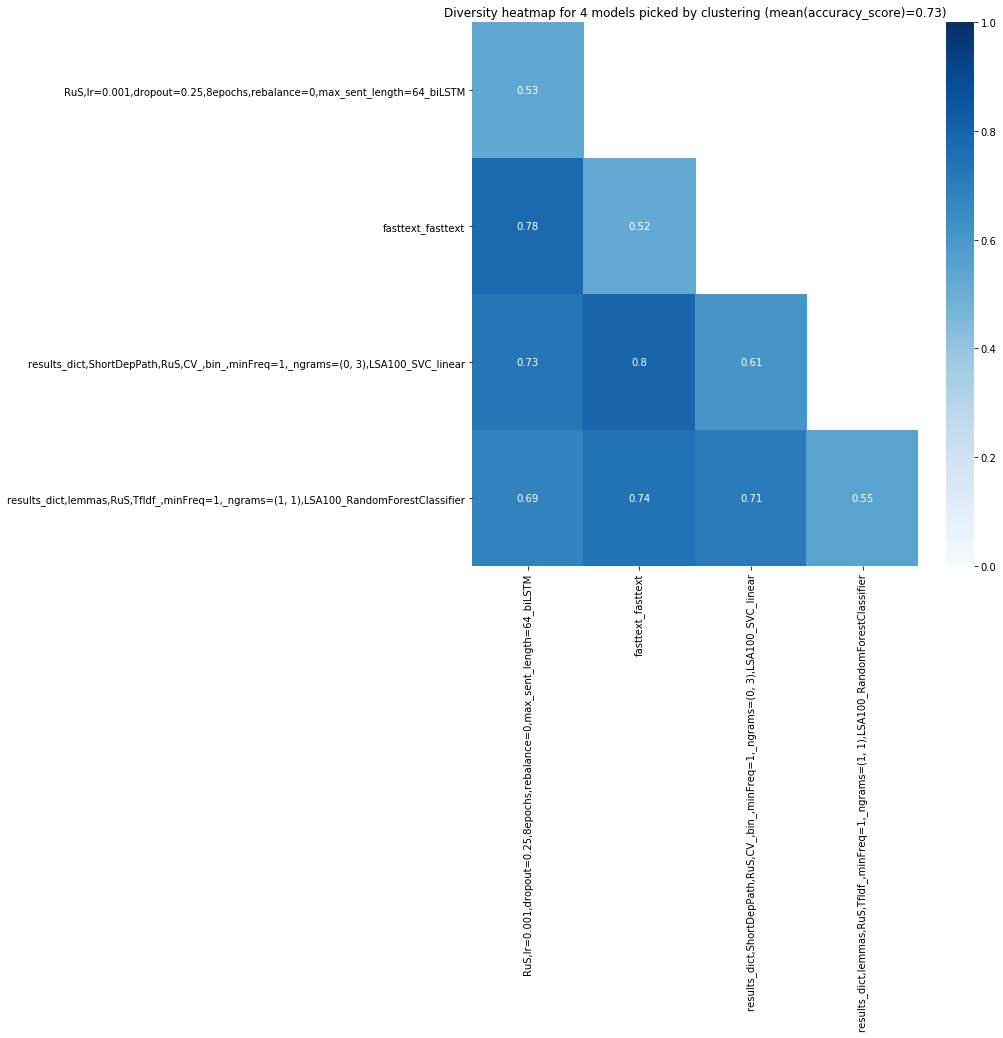

In [28]:
metric = accuracy_score

mean = diversity_matrix(
    results_dict,
    metric=accuracy_score,
    diagonal_key=None
).mean().mean()

diversity_heatmap(results_dict, 
                  metric=metric, diagonal_key='f1+', 
                  evaluate_on = "label_unlab_prob+",
                  title='Diversity heatmap for %i models picked by clustering (mean(%s)=%.2f)'%(
                      len(results_dict),metric.__name__, mean) )

In [29]:
# lowest_model_name = cohens_df.mean().idxmin()
# print cohens_df.mean().idxmin() , cohens_df.mean().min()

# Train the generative model (denoise)

In [30]:
from snorkel.annotations import LabelAnnotator

** with label generator **

In [31]:
def signal_annotator(c):
    """A generator over the different (worker_id, label_id) pairs for a Tweet."""
    for model in results_dict.keys():

        #hack to convert labels to -1,1....
        #TODO: switch back to unlab again
        yield model, (results_dict[model]['label_unlab_prob+'][c.id] >= 0.5)*2-1
#         yield model, (results_dict[model]['label_unlab_prob_dict'][c.id] > threshold)*2-1

#         try:
#             yield model, results_dict[model]['label_unlab_prob_dict'][c.id]
#         except:
#             yield model, 0

labeler = LabelAnnotator(label_generator=signal_annotator)

In [32]:
# Include the results for validation data
def signal_annotator_unlab_val(c):
    """A generator over the different (worker_id, label_id) pairs for a Tweet."""
    for model in results_dict.keys():

        #hack to convert labels to -1,1....
        try:
            yield model, (results_dict[model]['label_unlab_prob+'][c.id] >= 0.5)*2-1
        except:
            yield model, (results_dict[model]['label_val_prob+'][c.id] >= 0.5)*2-1


labeler = LabelAnnotator(label_generator=signal_annotator_unlab_val)

** with LFs **

In [32]:
# def predictions_exist_for(c):
#     """For now, skip unmapped candidates in the test set - as no predictions where generated for them."""
#     if c.id in results_dict[results_dict.keys()[0]]['label_unlab_prob_dict'].keys():
#         return True
#     else:
#         return False

In [33]:
# random_cand = session.query(REGULATOR).filter(REGULATOR.split==3).all()[0]

In [34]:
# predictions_exist_for(random_cand)

In [35]:
# results_dict['lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500'].keys()

In [36]:
# results_dict.keys()

In [37]:
# diversity_heatmap(results_dict, figsize=(20,20), metric=accuracy_score )

In [38]:
# cohens_df.columns

In [39]:
# ['RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,maxsentlength=64_biLSTM',
#  'trim=0,RuS,CV,bin,,stopw=english,LSA100_RandomForestClassifier',
# 'RuS,CV,bin,,stopw=english_RandomForestClassifier',
# ]

# def biLSTM(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['RuS,lr=0.001,dropout=0.25,15epochs,rebalance=0.25,max_sent_length=64_biLSTM']['label_unlab_prob_dict'][c.id]>=0.5 else 1
#     else:
#         return 0
        
# def BOW_TFidf_upto_3grams(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['results_dict,RuS,TfIdf_,minFreq=1,_stopw=english,_ngrams=(0, 3)_LogisticRegression']['label_unlab_prob_dict'][c.id]>=0.5 else 1
#     else:
#         return 0
    
# def BOW_CV_trimwindow0_LSA100_RF(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['results_dict,trim=0,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_RandomForestClassifier']['label_unlab_prob_dict'][c.id]>=0.5 else 1
#     else:
#         return 0
    
# def BOW_CV_trimwindow5_LSA100_SVCgaussian(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['results_dict,trim=5,RuS,CV_,bin_,minFreq=3,_stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>=0.5 else 1
#     else:
#         return 0
    
# def BOW_CV_RF(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['results_dict,RuS,CV_,bin_,minFreq=3,_stopw=english_RandomForestClassifier']['label_unlab_prob_dict'][c.id]>=0.5 else 1
#     else:
#         return 0

In [40]:
# # Pass classifier output as signals


# def mod1(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['trim=0,lemmas,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod2(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['trim=5,RuS,CV,bin,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod3(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod4(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict['RuS,TfIdf,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        

In [41]:
# # unlab

# # Pass classifier output as signals


# def mod1(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['trim=0,lemmas,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod2(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['trim=5,RuS,CV,bin,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod3(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['trim=5,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        
# def mod4(c):
#     if predictions_exist_for(c):
#         return -1 if results_dict1['RuS,TfIdf,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>0.5 else 1
#     else:
#         return 0
        

In [42]:
# # LFs = [mod1,mod2,mod3,mod4]
# LFs = [biLSTM,BOW_TFidf_upto_3grams,BOW_CV_trimwindow0_LSA100_RF,BOW_CV_trimwindow5_LSA100_SVCgaussian,BOW_CV_RF]
# labeler = LabelAnnotator(lfs=LFs)

# Start denoising

In [33]:
%time L_train = labeler.apply(split=3, parallelism=6)
L_train

Clearing existing...
Running UDF...
CPU times: user 5min 27s, sys: 12.1 s, total: 5min 39s
Wall time: 19min 55s


<79400x4 sparse matrix of type '<type 'numpy.int64'>'
	with 317600 stored elements in Compressed Sparse Row format>

In [34]:
# Determine parallelism
# on validation:

# parallelism=4
# CPU times: user 9.86 s, sys: 434 ms, total: 10.3 s
# Wall time: 38.7 s

# parallelism=6
# CPU times: user 9.05 s, sys: 389 ms, total: 9.44 s
# Wall time: 37.2 s
#          on unlab set:
# CPU times: user 3min 34s, sys: 8.25 s, total: 3min 42s
# Wall time: 14min 4s

# for n=12 classifiers takes 
# Wall time: 1h 2min 21s
    
# parallelism=7
# CPU times: user 11.4 s, sys: 428 ms, total: 11.8 s
# Wall time: 41.1 s
    
# parallelism=12
# CPU times: user 9.18 s, sys: 459 ms, total: 9.64 s
# Wall time: 38.5 s

In [35]:
# see how many LF vote on how many examples & with how many other LFs there are votes on common examples
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
fasttext_fasttext,0,1.0,1.0,0.473942
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.473942
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.473942
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.473942


In [36]:
# Find dependencies between LFs

from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.07)
len(deps)

6

### Hyperparameter search

In [46]:
from snorkel.learning import RandomSearch

In [140]:
# param_ranges = { # parameters for the fit function of the GenerativeModel
#     'step_size' : [1e-5, 1e-6, 1e-7],
#     'decay' : [1.0, 0.95, 0.9],
#     'epochs' : [20, 50, 100],
#     'reg_param': [5e-2,1e-1,2e-1,],
#     'reg_type': [1,2],    
# }

# model_class_params = {  # parameters for the GenerativeModel
#     'lf_propensity': [False]
# } 

# searcher = RandomSearch(GenerativeModel, param_ranges,  L_train, model_class_params = model_class_params , n=6 )

In [141]:
# L_train.shape

In [142]:
# %%time
# gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, n_threads=6 )
# run_stats

In [104]:
# run_stats

,Model,epochs,step_size,reg_type,reg_param,decay,Prec.,Rec.,F-1
4,2,100,1.000000e-07,1,0.10,1.00,0.605398,0.668085,0.635199
1,4,20,1.000000e-07,2,0.10,0.90,0.604621,0.668085,0.634771
3,3,100,1.000000e-06,2,0.20,0.95,0.604621,0.668085,0.634771
2,5,100,1.000000e-06,1,0.05,1.00,0.606218,0.663830,0.633717
5,0,100,1.000000e-07,1,0.20,1.00,0.605707,0.662411,0.632791
0,1,50,1.000000e-06,2,0.05,1.00,0.603871,0.663830,0.632432


In [110]:
# gen_model.load('GenerativeModel_4',save_dir='checkpoints/grid_search/')

[GenerativeModel] Model <GenerativeModel_4> loaded.


In [47]:
# train_marginals = gen_model.marginals(L_train)

### Normal training

In [53]:
%%time
### Normal training

# actual training of the gen. model
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=False, class_prior=True )
gen_model.train(
    L_train, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6,  threads = 6,
    deps=deps,
)

train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2
CPU times: user 2min 17s, sys: 141 ms, total: 2min 18s
Wall time: 1min 30s


In [47]:
# # plt.hist(train_marginals, bins=20)
# sns.distplot(train_marginals,bins=20)
# plt.title('Histogram of probabilistic labels (good_batch.pickle)')
# plt.show()

In [54]:
n_models = len(results_dict.keys())

In [55]:
from MLutils import diversity_matrix

In [56]:
diversity_matrix(results_dict,metric=accuracy_score).mean().mean()

0.80003869969040242

In [57]:
diversity_matrix(results_dict,metric=cohen_kappa_score).mean().mean()

0.5113189606834152

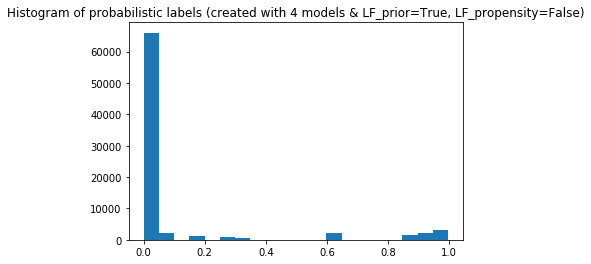

In [58]:
plt.hist(train_marginals, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & LF_prior=True, LF_propensity=False)'%n_models)
plt.show()

In [59]:
len(train_marginalsinals)

79400

In [60]:
print 'Inferred performance metrics by snorkel:'
gen_model.learned_lf_stats()

Inferred performance metrics by snorkel:


,Accuracy,Coverage,Precision,Recall
0,0.971729,0.8737,0.797044,0.820487
1,0.937507,0.8369,0.629160,0.805274
2,0.925276,0.8324,0.575373,0.781947
3,0.895110,0.8037,0.492881,0.737323


## Check performance on developer set

In [62]:
# TODO: to do that, we need to also take labels from a different dictionary

In [69]:
# load from db gold labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<3230x1 sparse matrix of type '<type 'numpy.int64'>'
	with 3230 stored elements in Compressed Sparse Row format>

In [70]:
L_dev = labeler.apply_existing(split=1, parallelism=6)

Clearing existing...
Running UDF...


In [65]:
L_dev

<3230x3 sparse matrix of type '<type 'numpy.int64'>'
	with 9690 stored elements in Compressed Sparse Row format>

In [63]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.968743,0.8734,0.800826,0.850746
1,0.941741,0.8342,0.671815,0.763828
2,0.926562,0.8211,0.618130,0.760316
3,0.897070,0.8054,0.529931,0.738367


In [68]:
gen_model.weights.lf_accuracy

array([ 1.32927991,  0.96930229,  0.89196357,  0.71774052])

In [71]:
gen_model.score(L_dev,L_gold_dev)

(0.67838312829525482, 0.54751773049645391, 0.60596546310832033)

In [62]:
gen_model.learned_lf_stats()['Accuracy']

0    0.966705
1    0.940499
2    0.924643
3    0.901990
Name: Accuracy, dtype: float64

In [82]:
L_dev.lf_stats(session, L_gold_dev,)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009


In [72]:
learned_stats = L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])
learned_stats

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384,0.968112
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904,0.935136
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133,0.924378
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009,0.896389


In [81]:
from sklearn.metrics import f1_score

In [83]:
for row in learned_stats.iterrows():
    print row[0]
    tp = row[1]['TP']
    tn = row[1]['TN']
    fp = row[1]['FP']
    fn = row[1]['FN']
    pr = float(tp)/(tp+fp)
    rec = float(tp)/(tp+fn)
    f1 = (2*pr*rec)/(pr+rec)
    print f1

fasttext_fasttext
0.516746411483
results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear
0.607655502392
RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM
0.534131736527
results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier
0.552310143388


In [67]:
# export to latex
print learned_stats.drop(labels=['j','Coverage', 'Overlaps', 'Conflicts'], axis=1).reset_index(drop=True).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &   TP &   FP &   FN &    TN &  Empirical Acc. &  Learned Acc. \\
\midrule
0 &  511 &  613 &  194 &  1912 &        0.750155 &      0.941921 \\
1 &  475 &  548 &  230 &  1977 &        0.759133 &      0.941634 \\
2 &  446 &  519 &  259 &  2006 &        0.759133 &      0.900665 \\
\bottomrule
\end{tabular}



### Try with priors = F1 score

In [87]:
gen_model_prior = GenerativeModel()

In [88]:
gen_model_prior.train(L_train, LF_acc_prior_weights=[0.5167, 0.60765, 0.5341, 0.5523 ])

Inferred cardinality: 2


### Put it in a log

In [157]:
gen_model_prior_log = GenerativeModel()

In [158]:
# TODO: try this from  snorkel/test/learning/test_supervised.py


LF_acc_priors = [0.5167, 0.60765, 0.5341, 0.5523 ]
cardinality = 2
LF_acc_prior_weights = [0.5 * np.log((cardinality - 1.0) * x / (1 - x)) for x in LF_acc_priors]


In [159]:
LF_acc_prior_weights

[0.033412428221050325,
 0.2187223798716636,
 0.068306034261486848,
 0.10498400583011107]

In [160]:
gen_model_prior_log.train(L_train, LF_acc_prior_weights=LF_acc_prior_weights)

Inferred cardinality: 2


### Compare results

In [161]:
gen_model_prior_log.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.936173,0.8006,0.938447,0.750098
1,0.901056,0.7671,0.906266,0.700312
2,0.871032,0.7498,0.874868,0.648380
3,0.837408,0.7362,0.844474,0.619094


In [90]:
gen_model_prior.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.953406,0.8220,0.956984,0.789125
1,0.909594,0.7776,0.912752,0.715650
2,0.895702,0.7632,0.899871,0.681349
3,0.853391,0.7462,0.861635,0.640811


In [89]:
gen_model.learned_lf_stats() # before passing LF_acc_prior_weights

,Accuracy,Coverage,Precision,Recall
0,0.971318,0.8751,0.760460,0.838524
1,0.940309,0.8410,0.599103,0.770473
2,0.929846,0.8239,0.554054,0.756632
3,0.896266,0.8088,0.449892,0.719723


In [179]:
L_train

(79400, 4)

In [177]:
L_train.row_index

{0: 40197,
 1: 40198,
 2: 40199,
 3: 40200,
 4: 40201,
 5: 40202,
 6: 40203,
 7: 40204,
 8: 40205,
 9: 40206,
 10: 40207,
 11: 40208,
 12: 40209,
 13: 40210,
 14: 40211,
 15: 40212,
 16: 40213,
 17: 40214,
 18: 40215,
 19: 40216,
 20: 40217,
 21: 40218,
 22: 40219,
 23: 40220,
 24: 40221,
 25: 40222,
 26: 40223,
 27: 40224,
 28: 40225,
 29: 40226,
 30: 40227,
 31: 40228,
 32: 40229,
 33: 40230,
 34: 40231,
 35: 40232,
 36: 40233,
 37: 40234,
 38: 40235,
 39: 40236,
 40: 40237,
 41: 40238,
 42: 40239,
 43: 40240,
 44: 40241,
 45: 40242,
 46: 40243,
 47: 40244,
 48: 40245,
 49: 40246,
 50: 40247,
 51: 40248,
 52: 40249,
 53: 40250,
 54: 40251,
 55: 40252,
 56: 40253,
 57: 40254,
 58: 40255,
 59: 40256,
 60: 40257,
 61: 40258,
 62: 40259,
 63: 40260,
 64: 40261,
 65: 40262,
 66: 40263,
 67: 40264,
 68: 40265,
 69: 40266,
 70: 40267,
 71: 40268,
 72: 40269,
 73: 40270,
 74: 40271,
 75: 40272,
 76: 40273,
 77: 40274,
 78: 40275,
 79: 40276,
 80: 40277,
 81: 40278,
 82: 40279,
 83: 40280,
 8

### Get and plot marginals

In [91]:
train_marginals_w_prior = gen_model_prior.marginals(L_train)

In [162]:
train_marginals_w_prior_log = gen_model_prior_log.marginals(L_train)

In [ ]:
# Plug in directly the F1 score as Lf_accuracy

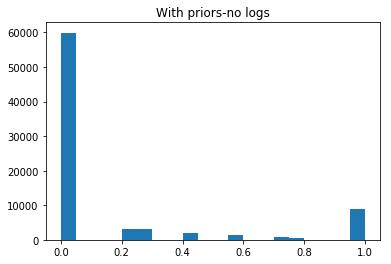

In [167]:
plt.hist(train_marginals_w_prior, bins=20)
plt.title('With priors-no logs')
plt.show()

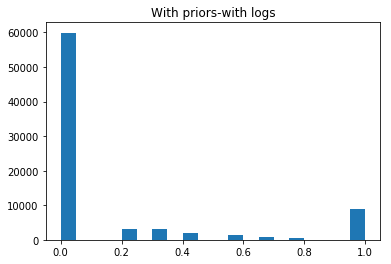

In [168]:
plt.hist(train_marginals_w_prior_log, bins=20)
plt.title('With priors-with logs')
plt.show()

In [180]:
L_train

<79400x4 sparse matrix of type '<type 'numpy.int64'>'
	with 317600 stored elements in Compressed Sparse Row format>

### Rebalance dataset on the generative model

In [182]:
from MLutils import balance_candidates

In [181]:
# from https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices
import numpy as np
from scipy.sparse import csr_matrix

def delete_from_csr(mat, row_indices=[], col_indices=[]):
    """
    Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
    WARNING: Indices of altered axes are reset in the returned matrix
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if row_indices:
        rows = list(row_indices)
    if col_indices:
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat

In [190]:
(5>3).asint

AttributeError: 'bool' object has no attribute 'asint'

In [191]:
list(map(lambda x:x[0].item()>=0.5,L_train.mean(axis=1)))

array(<itertools.imap object at 0x7f1c085ecb10>, dtype=object)

In [201]:
arr = np.fromiter(map(lambda x:x[0].item()>=0.5,L_train.mean(axis=1)), dtype=bool)
lbls = arr*2-1

In [202]:
lbls

array([-1, -1, -1, ..., -1, -1,  1])

In [204]:
indices = [i for i in range(L_train.shape[0])]

In [208]:
ind_us, lbls_us = balance_candidates(indices, lbls)

In [ ]:
#keep only those which are in the ind_us

In [209]:
ind_to_del = list(set(indices).difference(set(ind_us)))

In [250]:
deps

{(0, 1, 0), (0, 2, 0), (0, 3, 0), (1, 2, 0), (1, 3, 0), (2, 3, 0)}

Inferred cardinality: 2


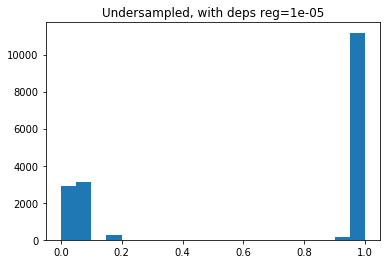

Inferred cardinality: 2


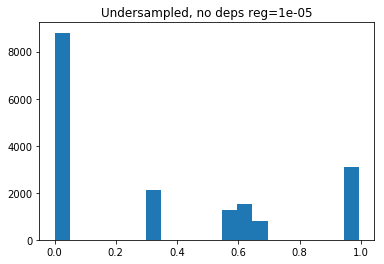

Inferred cardinality: 2


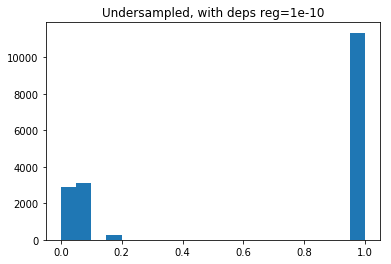

Inferred cardinality: 2


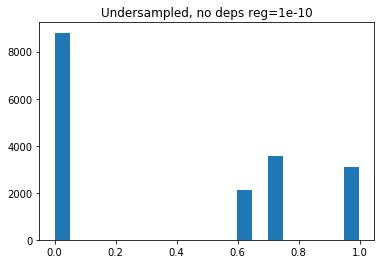

Inferred cardinality: 2


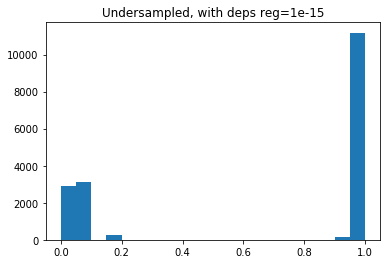

Inferred cardinality: 2


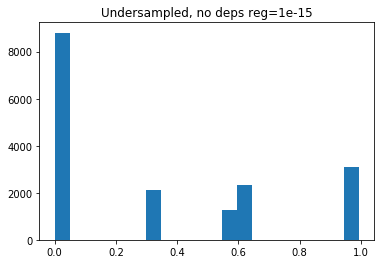

In [251]:
for reg_param in [1e-5,1e-10,1e-15]:
    gen_model.train(L_train_us,threads=6, reg_param=reg_param, deps=deps)
    train_marginals_us = gen_model.marginals(L_train_us)
    
    plt.hist(train_marginals_us, bins=20)
    plt.title('Undersampled, with deps reg=%s'%reg_param)
    plt.show()
    
    gen_model.train(L_train_us,threads=6, reg_param=reg_param)
    train_marginals_us = gen_model.marginals(L_train_us)
    
    plt.hist(train_marginals_us, bins=20)
    plt.title('Undersampled, no deps reg=%s'%reg_param)
    plt.show()
    

Inferred cardinality: 2


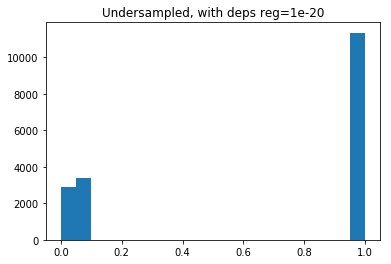

Inferred cardinality: 2


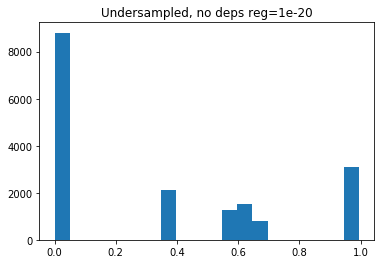

Inferred cardinality: 2


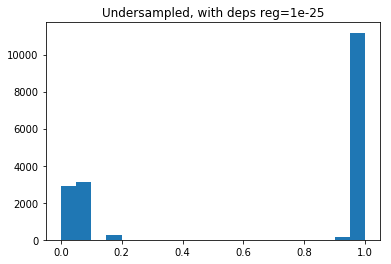

Inferred cardinality: 2


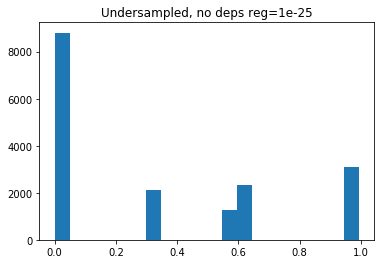

Inferred cardinality: 2


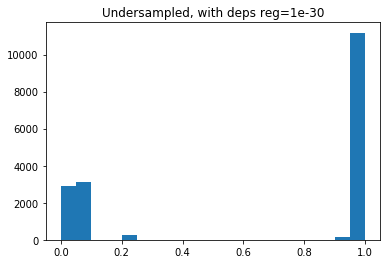

Inferred cardinality: 2


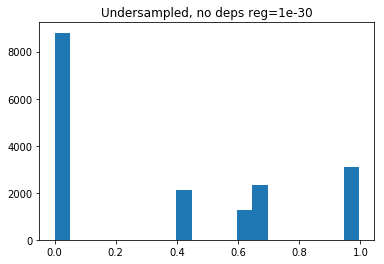

In [252]:
for reg_param in [1e-20,1e-25,1e-30]:
    gen_model.train(L_train_us,threads=6, reg_param=reg_param, deps=deps)
    train_marginals_us = gen_model.marginals(L_train_us)
    
    plt.hist(train_marginals_us, bins=20)
    plt.title('Undersampled, with deps reg=%s'%reg_param)
    plt.show()
    
    gen_model.train(L_train_us,threads=6, reg_param=reg_param)
    train_marginals_us = gen_model.marginals(L_train_us)
    
    plt.hist(train_marginals_us, bins=20)
    plt.title('Undersampled, no deps reg=%s'%reg_param)
    plt.show()
    

Inferred cardinality: 2


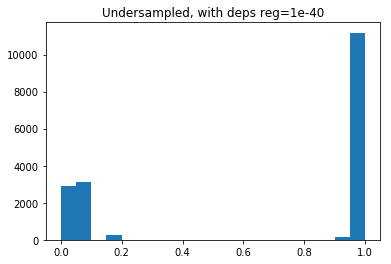

Inferred cardinality: 2


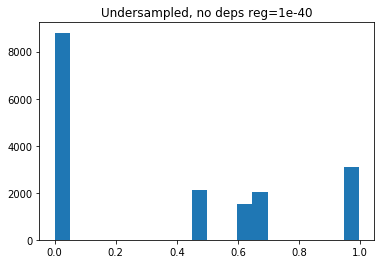

Inferred cardinality: 2


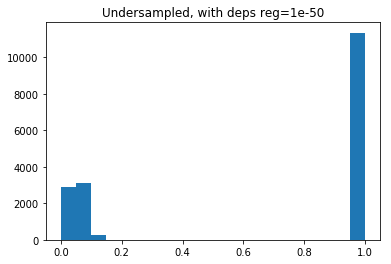

Inferred cardinality: 2


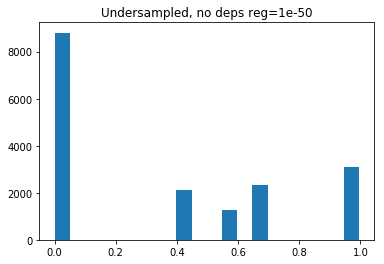

Inferred cardinality: 2


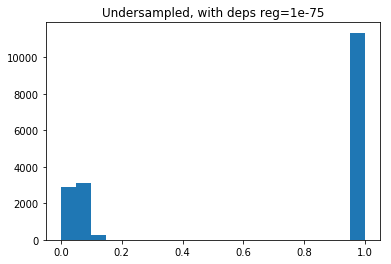

Inferred cardinality: 2


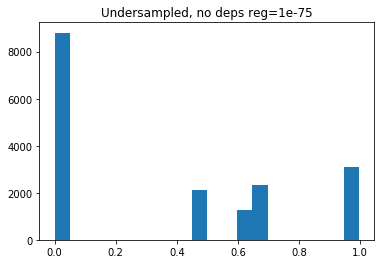

In [253]:
for reg_param in [1e-40,1e-50,1e-75]:
    gen_model.train(L_train_us,threads=6, reg_param=reg_param, deps=deps)
    train_marginals_us = gen_model.marginals(L_train_us)
    
    plt.hist(train_marginals_us, bins=20)
    plt.title('Undersampled, with deps reg=%s'%reg_param)
    plt.show()
    
    gen_model.train(L_train_us,threads=6, reg_param=reg_param)
    train_marginals_us = gen_model.marginals(L_train_us)
    
    plt.hist(train_marginals_us, bins=20)
    plt.title('Undersampled, no deps reg=%s'%reg_param)
    plt.show()
    

In [219]:
gen_model.weights.lf_accuracy

array([ 1.14998382,  1.21349223,  1.23895636,  1.26662926])

In [220]:
gen_model_prior.weights.lf_accuracy

array([ 1.49332416,  1.15567761,  1.06542223,  0.91683275])

In [221]:
gen_model_prior_log.weights.lf_accuracy

array([ 1.3412863 ,  1.08157638,  0.96753462,  0.84560977])

# ~

In [163]:
gen_model.weights.lf_accuracy

array([ 0.5167 ,  0.60765,  0.5341 ,  0.5523 ])

In [99]:
np.array([0.5167, 0.60765, 0.5341, 0.5523 ])

array([ 0.5167 ,  0.60765,  0.5341 ,  0.5523 ])

In [100]:
gen_model.weights.lf_accuracy = np.array([0.5167, 0.60765, 0.5341, 0.5523 ])

In [101]:
train_marginals_F1 = gen_model.marginals(L_train)

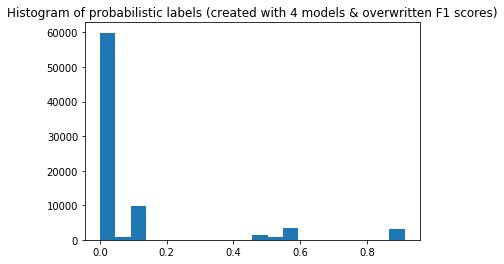

In [134]:
plt.hist(train_marginals_F1, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & overwritten F1 scores)'%n_models)
plt.show()

In [222]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
fasttext_fasttext,0,1.0,1.0,0.486687,324,225,381,2300,0.812384,0.909559
"results_dict,ShortDepPath,RuS,CV_,bin_,minFreq=1,_ngrams=(0, 3),LSA100_SVC_linear",1,1.0,1.0,0.486687,508,459,197,2066,0.796904,0.914668
"RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64_biLSTM",2,1.0,1.0,0.486687,446,519,259,2006,0.759133,0.925470
"results_dict,lemmas,RuS,TfIdf_,minFreq=1,_ngrams=(1, 1),LSA100_RandomForestClassifier",3,1.0,1.0,0.486687,520,658,185,1867,0.739009,0.925073


In [225]:
gen_model.weights.lf_accuracy

array([ 1.14998382,  1.21349223,  1.23895636,  1.26662926])

In [184]:
L_train.mean(axis=1)[0].item()

-1.0

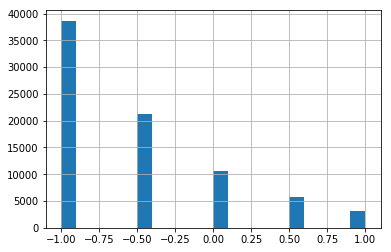

In [169]:
#this would be with unweighted voting

pd.Series(list(map(lambda x:x[0].item(),L_train.mean(axis=1)))).hist(bins=20)

In [136]:
import math
import numpy as np
import scipy.sparse as sparse
from multiprocessing import Process, Queue
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from snorkel.models import FeatureKey, GoldLabel, Sentence, Span, Candidate
from snorkel.learning.utils import print_scores

def majority_vote(L):
    '''Majority vote'''
    pred = L.sum(axis=1)
    pred[(pred > 0).nonzero()[0]] = 1
    pred[(pred < 0).nonzero()[0]] = 0
    return pred

def majority_vote_score(L, gold_labels):
    
    y_pred = np.ravel(majority_vote(L))
    y_true = gold_labels.todense()
    y_true = [1 if y_true[i] == 1 else 0 for i in range(y_true.shape[0])]
    
    pos,neg = y_true.count(1),float(y_true.count(0))
    print "pos/neg    {:d}:{:d} {:.1f}%/{:.1f}%".format(int(pos), int(neg), pos/(pos+neg)*100, neg/(pos+neg)*100)
    print "precision  {:.2f}".format( 100 * precision_score(y_true, y_pred) )
    print "recall     {:.2f}".format( 100 * recall_score(y_true, y_pred) )
    print "f1         {:.2f}".format( 100 * f1_score(y_true, y_pred) )
    #print "accuracy  {:.2f}".format( 100 * accuracy_score(y_true, y_pred) 


In [137]:
majority_vote_score(L_dev, L_gold_dev)

pos/neg    705:2525 21.8%/78.2%
precision  67.84
recall     54.75
f1         60.60


In [ ]:
# 

In [138]:
L_dev.

<1x4 sparse matrix of type '<type 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [142]:
l_i = L_dev[0].tocoo()

In [143]:
l_i.data[0]

-1

In [146]:
l_i.col[3]

3

In [ ]:
logp_false = e^10
logp_true = e

In [ ]:
1 / (1 + np.exp(logp_false - logp_true))

In [154]:
gen_model.weights.dep_similar

<4x4 sparse matrix of type '<type 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

## save probabilistic labels for the LSTM  -  this is the # of train. examples our LSTM will train on

In [68]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 79400 marginals


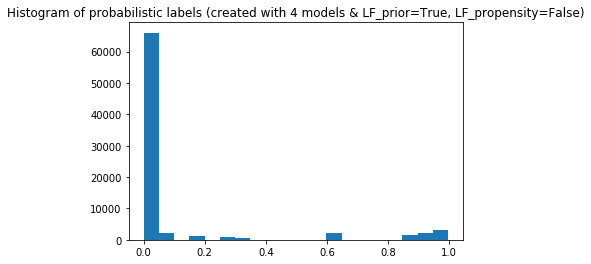

In [93]:
plt.hist(train_marginals, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & LF_prior=True, LF_propensity=False)'%n_models)
plt.show()

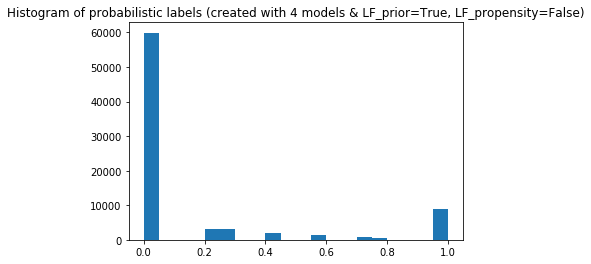

In [92]:
plt.hist(train_marginals_w_prior, bins=20)
plt.title('Histogram of probabilistic labels (created with %i models & LF_prior=True, LF_propensity=False)'%n_models)
plt.show()

# ~~ 

In [47]:
L_test = labeler.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%



In [49]:
# load from db gold labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<13350x1 sparse matrix of type '<type 'numpy.int64'>'
	with 5781 stored elements in Compressed Sparse Row format>

In [50]:
_ = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.259
Neg. class accuracy: 0.975
Precision            0.57
Recall               0.259
F1                   0.356
----------------------------------------
TP: 388 | FP: 293 | TN: 11557 | FN: 1112



In [51]:
L_test.lf_stats(session, L_gold_test, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
dummy,0,1.000000,0.433034,0.128764,0,0,1500,4281,0.740529,0.936173
LogisticRegression,1,0.433034,0.433034,0.128764,683,563,817,3718,0.761287,0.893057
SVC_linear,2,0.433034,0.433034,0.128764,594,592,906,3689,0.740875,0.888321
SVC_rbf_C100,3,0.433034,0.433034,0.128764,606,500,894,3781,0.758865,0.893826
SVC_rbf_C500,4,0.433034,0.433034,0.128764,625,484,875,3797,0.764920,0.897841
SVC_rbf_C1000,5,0.433034,0.433034,0.128764,577,480,923,3801,0.757308,0.899282
